# Notebook for Classification Report and Confusion Matrix

## Rasterize function

In [1]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

## Load Gesture Data

In [2]:
import glob
import json

all_strokes = []
for filename in glob.glob("gestures_data/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    all_strokes.append(stroke)

# Total number of strokes
print("Total number of strokes collected: ", len(all_strokes))

strokes = [] # initialize variable to store strokes with labels
for stroke in all_strokes:
  if stroke["label"] != "":
    strokes.append(stroke)

# Total number of strokes with labels
print("Total number of strokes with labels: ", len(strokes))


Total number of strokes collected:  1456
Total number of strokes with labels:  1317


## Save Rasterize Images Function

In [3]:
!rm -rf test
!rm -rf train
!rm -rf validation

In [4]:
from pathlib import Path
import shutil

X_RANGE = 0.7
Y_RANGE = 0.7

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
      label_path = Path(root_folder, label)
      ensure_empty_dir(label_path)

  label_counts = {}
  label_augment_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))

    # For counting how many un-augmented images are there for each label
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1

    # Rasterize normal strokes
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))

    #Augment and Rasterize a set of strokes
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))
      #label count for augmented images
      if label not in label_augment_counts:
        label_augment_counts[label] = 0
      label_augment_count = label_augment_counts[label]
      label_augment_counts[label] += 1
  print('label counts of un-augmented images for', root_folder, ': ', label_counts)
  print('label counts of augmented images for', root_folder, ': ', label_augment_counts)


## Split Dataset

In [5]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)
print(len(shuffled_strokes))
test_percentage = 20
validation_percentage = 20
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

1317


## Save Image Datasets

In [6]:
# Save strokes into folder
save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

label counts of un-augmented images for test :  {'2': 46, '4': 66, '0': 46, '1': 53, '3': 52}
label counts of augmented images for test :  {'2': 460, '4': 660, '0': 460, '1': 530, '3': 520}
label counts of un-augmented images for validation :  {'3': 49, '2': 45, '1': 55, '4': 67, '0': 47}
label counts of augmented images for validation :  {}
label counts of un-augmented images for train :  {'0': 164, '3': 156, '4': 171, '1': 166, '2': 134}
label counts of augmented images for train :  {'0': 1640, '3': 1560, '4': 1710, '1': 1660, '2': 1340}


## Evaluate Base Model

NOTE: The above datasets were re-created similar to when we trained the model. However only the test dataset will be used for evaluation

NOTE: Make sure you upload the `base_8_16_32_model.h5` file into colab

In [9]:
#Load Base Model
from keras.models import load_model
model = load_model('base_8_16_32_model.h5')

In [12]:
def predict_image(model, filename):
  classes = ["0: Swipe up", "1: Swipe down", "2: Hand wave", "3:Clockwise", "4:Counter-clockwise"]
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array, verbose=0).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  img_class = classes[np.argmax(predictions)]
  return (predicted_label_index, predicted_score, img_class)

In [41]:
correct_count = 0
wrong_count = 0
discarded_count = 0
SCORE_THRESHOLD = 0.5
true_labels = []
predicted_labels = []
for label_dir in glob.glob("test/*"):
  label = int(label_dir.replace("test/", ""))
  #print("label:", label)
  for filename in glob.glob(label_dir + "/*.png"):
    index, score, img_class = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
    #   continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
    true_labels.append(label) # Store true labels
    predicted_labels.append(index) # Store predicted labels
correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
print("%.1f%% correct (N=%d, %d below threshold)" % (correct_percentage, (correct_count + wrong_count), discarded_count))


86.4% correct (N=2893, 136 below threshold)


In [19]:
print("True Labels length: ", len(true_labels))
print("Predicted Labels length: ", len(predicted_labels))
print("True Labels: ", true_labels[:20])
print("Predicted Labels : ", predicted_labels[:20])

True Labels length:  2893
Predicted Labels length:  2893
True Labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted Labels :  [0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


In [45]:
from sklearn.metrics import confusion_matrix, classification_report
# Print classification report
print("Base Model Classification report:")
print(classification_report(true_labels, predicted_labels,target_names=["0: Swipe up", "1: Swipe down", "2: Hand wave", "3:Clockwise", "4:Counter-clockwise"]))
# Print confusion matrix
print("Base Model Confusion matrix:")
print(confusion_matrix(true_labels, predicted_labels), "\n")

Base Model Classification report:
                     precision    recall  f1-score   support

        0: Swipe up       0.76      0.81      0.79       506
      1: Swipe down       0.80      0.80      0.80       583
       2: Hand wave       0.85      0.94      0.89       506
        3:Clockwise       0.90      0.85      0.88       572
4:Counter-clockwise       0.98      0.91      0.94       726

           accuracy                           0.86      2893
          macro avg       0.86      0.86      0.86      2893
       weighted avg       0.87      0.86      0.87      2893

Base Model Confusion matrix:
[[410  83   9   2   2]
 [104 467   6   3   3]
 [  7  18 474   6   1]
 [  6  11  60 488   7]
 [  9   3  10  43 661]] 



## Evalute Quantized Model

NOTE: Make sure you upload the `quant_8_16_32_model.tfl` file into colab

In [26]:
def predict_tflite(filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Passing the Base TF Lite model to the interpreter.
  interpreter = tf.lite.Interpreter('quant_8_16_32_model.tfl') # Load quantized base model
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [46]:
SCORE_THRESHOLD = 0.5
correct_count = 0
wrong_count = 0
discarded_count = 0
true_quant_labels = []
predicted_quant_labels = []
for label_dir in glob.glob("test/*"):
  label = int(label_dir.replace("test/", ""))
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_tflite(filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
    true_quant_labels.append(label)
    predicted_quant_labels.append(index)
correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

print("%.1f%% correct (N=%d, %d below threshold)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

86.4% correct (N=2893, 153 below threshold)


In [47]:
print("True Quant Labels length: ", len(true_quant_labels))
print("Predicted Quant Labels length: ", len(predicted_quant_labels))
print("True Quant Labels: ", true_quant_labels[:20])
print("Predicted Quant Labels : ", predicted_quant_labels[:20])

True Quant Labels length:  2893
Predicted Quant Labels length:  2893
True Quant Labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted Quant Labels :  [0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]


In [48]:
from sklearn.metrics import confusion_matrix, classification_report
# Print classification report
print("Quantized Model Classification report:")
print(classification_report(true_quant_labels, predicted_quant_labels,target_names=["0: Swipe up", "1: Swipe down", "2: Hand wave", "3:Clockwise", "4:Counter-clockwise"]))
# Print confusion matrix
print("Quantized Model Confusion matrix:")
print(confusion_matrix(true_quant_labels, predicted_quant_labels), "\n")

Quantized Model Classification report:
                     precision    recall  f1-score   support

        0: Swipe up       0.76      0.81      0.78       506
      1: Swipe down       0.80      0.80      0.80       583
       2: Hand wave       0.86      0.93      0.89       506
        3:Clockwise       0.90      0.85      0.88       572
4:Counter-clockwise       0.98      0.91      0.95       726

           accuracy                           0.86      2893
          macro avg       0.86      0.86      0.86      2893
       weighted avg       0.87      0.86      0.87      2893

Quantized Model Confusion matrix:
[[412  83   7   2   2]
 [108 464   4   4   3]
 [  9  17 473   6   1]
 [  7  11  60 488   6]
 [  8   3   9  43 663]] 



## Plot Pretty Confusion Matrix

In [39]:
classes = ["0: Swipe up", "1: Swipe down", "2: Hand wave", "3:Clockwise", "4:Counter-clockwise"]

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


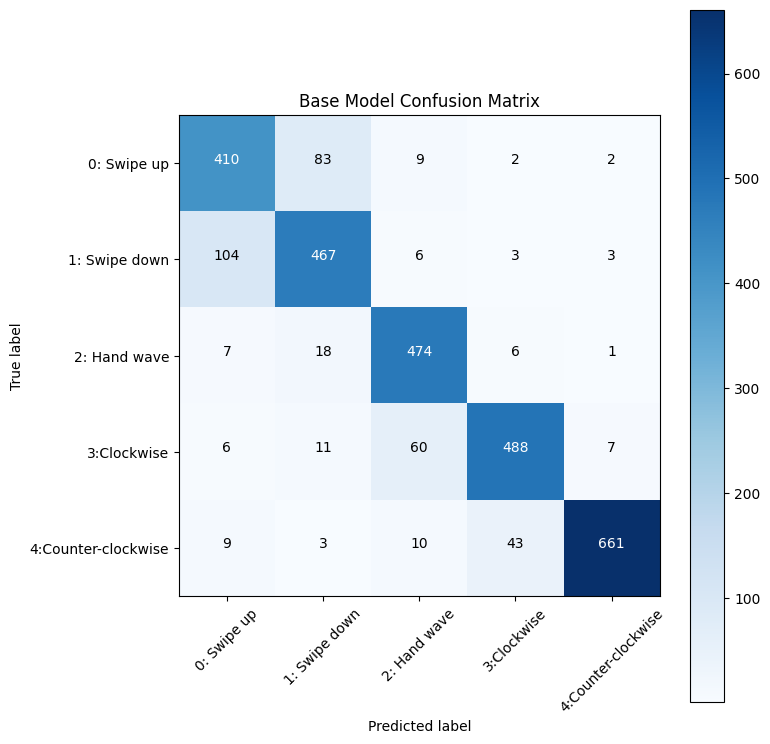

In [43]:
# Compute Base Model confusion matrix
cm_base = confusion_matrix(true_labels, predicted_labels)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_base, classes=classes, title='Base Model Confusion Matrix')
plt.show()


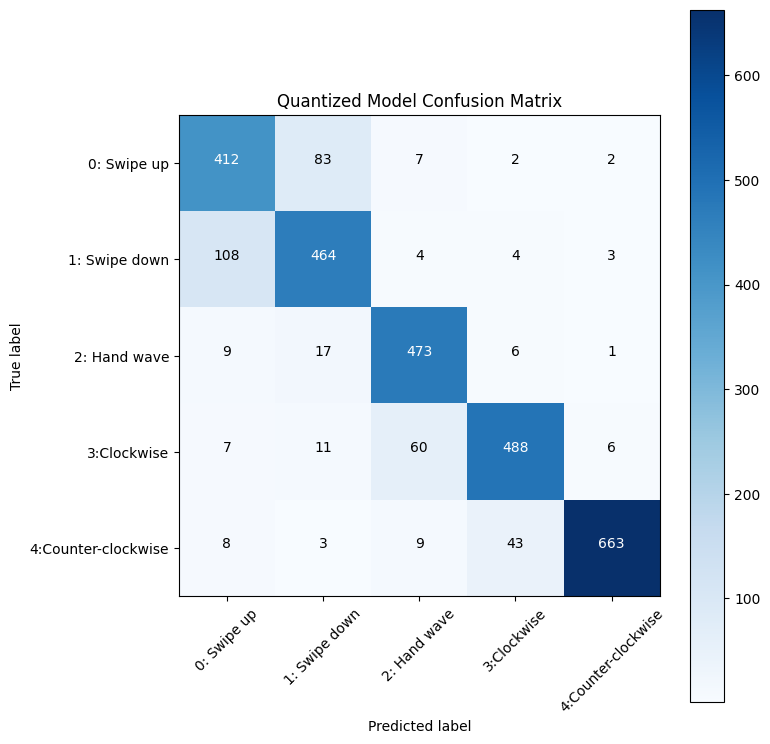

In [44]:
# Compute Qunatized Model confusion matrix
cm_quant = confusion_matrix(true_quant_labels, predicted_quant_labels)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_quant, classes=classes, title='Quantized Model Confusion Matrix')
plt.show()


## OLD IMPLEMENTATION - NOT USED

In [37]:
# Extracting and saving train images and labels from the train dataset.
train_images = []
train_labels = []
for image, label in train_ds.take(len(train_ds)).unbatch():
    train_images.append(image)
    train_labels.append(label)

In [36]:
# Extracting and saving test images and labels from the test dataset.
test_images = []
test_labels = []
for image, label in validation_ds.take(len(validation_ds)).unbatch():
    test_images.append(image)
    test_labels.append(label)

In [38]:
test_labels = np.argmax(test_labels, axis=1)
print('test_labels: ', test_labels)

test_labels:  [2 4 4 0 4 0 0 4 2 4]


Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.




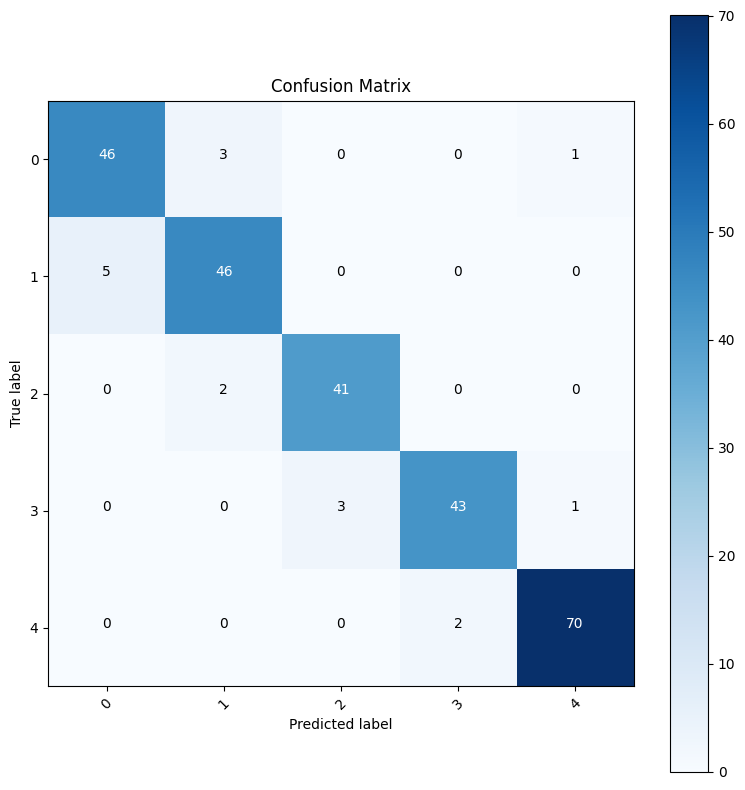

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        50
           1       0.90      0.90      0.90        51
           2       0.93      0.95      0.94        43
           3       0.96      0.91      0.93        47
           4       0.97      0.97      0.97        72

    accuracy                           0.94       263
   macro avg       0.93      0.93      0.93       263
weighted avg       0.94      0.94      0.94       263



In [ ]:
interpreter = tf.lite.Interpreter('base_8_16_32_model.tfl')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

prediction= []
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
input_format = interpreter.get_output_details()[0]['dtype']

for i, test_image in enumerate(test_images):
    if i % 100 == 0:
        print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)

print('\n')
# Comparing prediction results with ground truth labels to calculate accuracy.
prediction = np.array(prediction)

# Actual labels
y_true = test_labels

# Compute confusion matrix
cm = confusion_matrix(y_true, prediction)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=[0,1,2,3,4], title='Confusion Matrix')
plt.show()

# Print classification report f
print('Classification Report')
print(classification_report(y_true, prediction))

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.




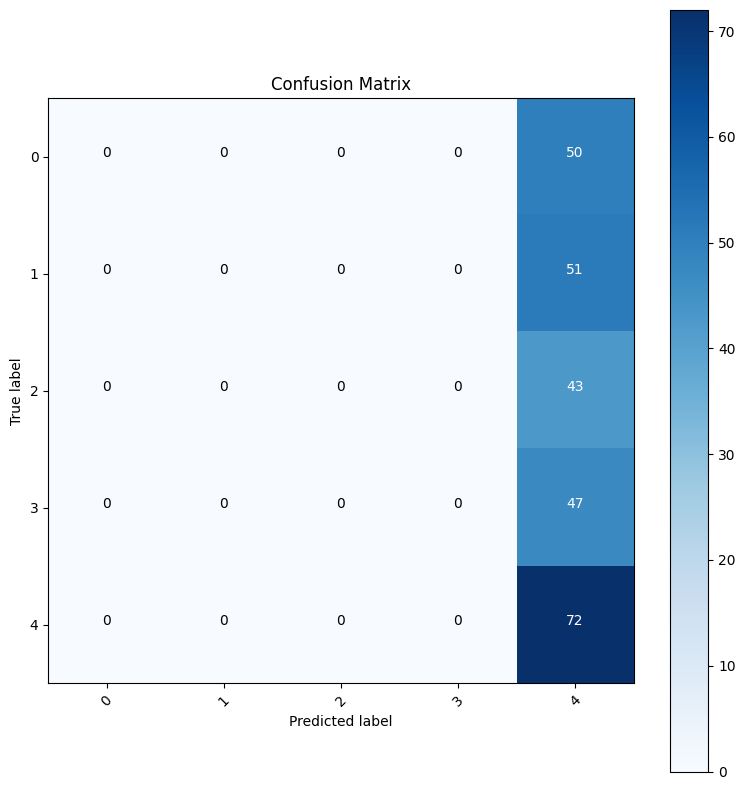

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00        47
           4       0.27      1.00      0.43        72

    accuracy                           0.27       263
   macro avg       0.05      0.20      0.09       263
weighted avg       0.07      0.27      0.12       263



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
interpreter = tf.lite.Interpreter('quant_8_16_32_model.tfl')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

prediction= []
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
input_format = interpreter.get_output_details()[0]['dtype']

for i, test_image in enumerate(test_images):
    if i % 100 == 0:
        print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)

print('\n')
# Comparing prediction results with ground truth labels to calculate accuracy.
prediction = np.array(prediction)

# Actual labels
y_true = test_labels

# Compute confusion matrix
cm = confusion_matrix(y_true, prediction)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=[0,1,2,3,4], title='Confusion Matrix')
plt.show()

# Print classification report f
print('Classification Report')
print(classification_report(y_true, prediction))